**Goal:** create a heatmap showing the density of platforms for one typical day, taken from the latest directory in ftp://ftp1.ifremer.fr

In [110]:
import folium
import glob
import numpy as np
import os
import netCDF4
import matplotlib.pyplot as plt
from matplotlib import colors
from geopy.geocoders import Nominatim
from folium import plugins
%matplotlib inline

In [35]:
period = '20160815'
datadir = '/data_local/DataOceano/CMEMS/INSITU_GLO_NRT_OBSERVATIONS_013_030/latest/' + period + '/'

# Loop on the files and read coordinates

In [135]:
def get_coordinates(datafile):
    with netCDF4.Dataset(datafile) as nc:
        if nc.source == u'Mooring Observation':
            lon = nc.variables['LONGITUDE'][0]
            lat = nc.variables['LATITUDE'][0]
        else:
            lon = nc.variables['LONGITUDE'][:]
            lat = nc.variables['LATITUDE'][:]
    return lon, lat

In [132]:
def create_gradient(cb, ncolors):
    '''
    From a given matplotlib color palette, 
    provide a gradient dictionnary to be passed to 
    the heatmap function of folium
    INPUTS: cb = matplotlib colormap
            ncolors = number of colors
    OUTPUT: gradient = dictionnary containing the color
    '''
    gradient = {}
    for i, j in zip(np.linspace(0.5, 1.0, ncolors), np.linspace(0., cb.N-1, ncolors).astype('uint8')):
        gradient[i] = colors.rgb2hex(cb.colors[j])
    return gradient

In [138]:
datafilelist = sorted(glob.glob(datadir + '*.nc'))
gradient = create_gradient(plt.cm.plasma, 10)
lonlist, latlist = np.array([]), np.array([])
for datafiles in datafilelist[0:]:
    #print(os.path.basename(datafiles))
    lon, lat = get_coordinates(datafiles)
    
    lonlist = np.append(lonlist, lon)
    latlist = np.append(latlist, lat)
    
badcoords = np.where(np.logical_or(abs(lonlist) > 180., abs(latlist) > 90.))[0]
lonlist = np.delete(lonlist, badcoords)
latlist = np.delete(latlist, badcoords)

In [149]:
nancoords = np.where(np.logical_or(np.isnan(lonlist), np.isnan(latlist)))[0]
lonlist = np.delete(lonlist, nancoords)
latlist = np.delete(latlist, nancoords)
coords2plot = np.vstack((latlist, lonlist)).T

# Simple plot

To see if the coordinates make sense.

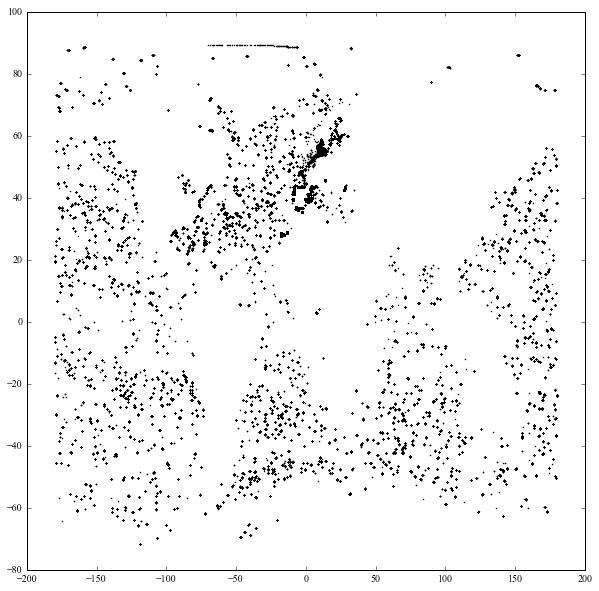

In [150]:
plt.figure(figsize=(10, 10))
plt.plot(lonlist, latlist, 'ko', ms=1)
plt.show()

# Leaflet plot

In [155]:
tile_url='http://services.arcgisonline.com/arcgis/rest/services/Ocean/World_Ocean_Base/MapServer/tile/{z}/{y}/{x}'
tile_url='http://services.arcgisonline.com/ArcGIS/rest/services/Canvas/World_Dark_Gray_Base/MapServer/tile/{z}/{y}/{x}'

map_platform = folium.Map(location=[0.0, 0.0], zoom_start=2, tiles=tile_url, attr='World Ocean Base')
# map_platform.add_tile_layer(tile_name='World Topo Map', tile_url='http://services.arcgisonline.com/arcgis/rest/services/World_Topo_Map/MapServer/MapServer/tile/{z}/{y}/{x}')
#map_platform.add_tile_layer(tile_name='World Ocean Reference', tile_url='http://services.arcgisonline.com/arcgis/rest/services/Ocean/World_Ocean_Reference/MapServer/tile/{z}/{y}/{x}')
folium.plugins.HeatMap(coords2plot, radius=5, blur=2, 
                       gradient=gradient).add_to(map_platform)
map_platform